Some Text

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL
import PIL.Image
import pathlib

print(tf.__version__)

2.12.0


Describe image directory

In [2]:
data_dir = pathlib.Path("data/training/picture")
print(data_dir)

data/training/picture


Create dataset

In [3]:
batch_size = 32
img_height = 180
img_width = 180

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1798 files belonging to 2 classes.
Using 1439 files for training.
Metal device set to: Apple M2 Pro


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1798 files belonging to 2 classes.
Using 359 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['seed', 'sprout']


2023-05-01 15:45:58.555561: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


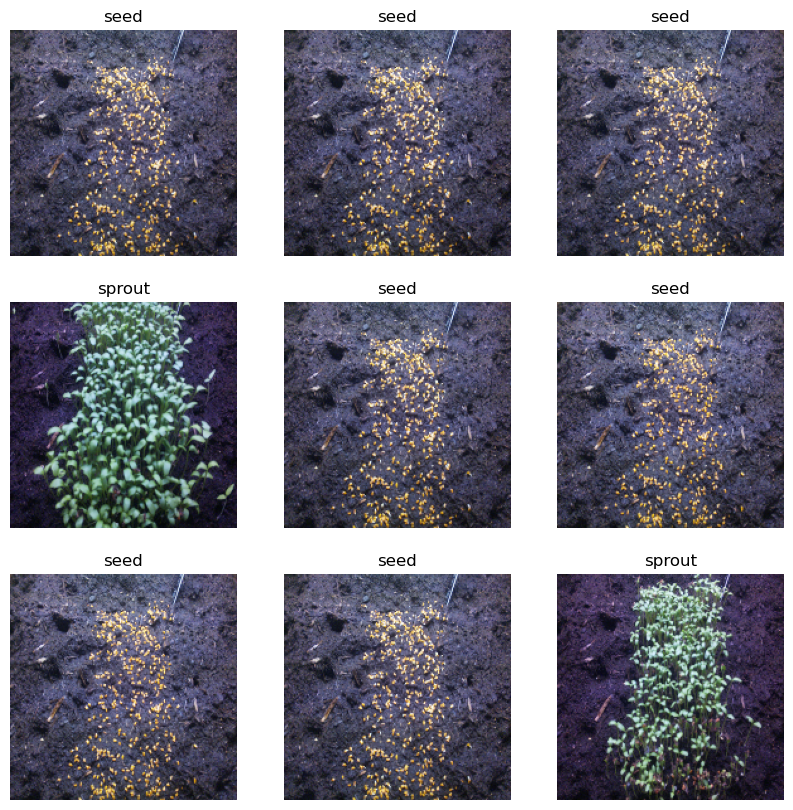

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 180, 180, 3)
(32,)


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [11]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [12]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
45/45 [==============================] - 11s 196ms/step - loss: 0.2561 - accuracy: 0.9083 - val_loss: 0.0447 - val_accuracy: 0.9889
Epoch 2/10
45/45 [==============================] - 2s 35ms/step - loss: 0.0196 - accuracy: 0.9951 - val_loss: 0.0117 - val_accuracy: 0.9972
Epoch 3/10
45/45 [==============================] - 1s 31ms/step - loss: 7.0063e-04 - accuracy: 1.0000 - val_loss: 0.0061 - val_accuracy: 0.9972
Epoch 4/10
45/45 [==============================] - 1s 31ms/step - loss: 7.1961e-05 - accuracy: 1.0000 - val_loss: 0.0076 - val_accuracy: 0.9972
Epoch 5/10
45/45 [==============================] - 1s 31ms/step - loss: 4.0105e-05 - accuracy: 1.0000 - val_loss: 0.0087 - val_accuracy: 0.9972
Epoch 6/10
45/45 [==============================] - 1s 31ms/step - loss: 2.8008e-05 - accuracy: 1.0000 - val_loss: 0.0094 - val_accuracy: 0.9972
Epoch 7/10
45/45 [==============================] - 1s 31ms/step - loss: 2.1087e-05 - accuracy: 1.0000 - val_loss: 0.0100 - val_accuracy

In [13]:
import datetime

now = datetime.datetime.now()

model_dir = 'data/model/' + now.strftime("%Y-%m-%d-%H-%M-%S") + "_sprout_detect"
model.save(model_dir)

print("Model saved at " + model_dir)

INFO:tensorflow:Assets written to: data/model/2023-05-01-15-46-25_sprout_detect/assets


INFO:tensorflow:Assets written to: data/model/2023-05-01-15-46-25_sprout_detect/assets


Model saved at data/model/2023-05-01-15-46-25_sprout_detect


In [14]:
# Convert the model for tf flite
converter = tf.lite.TFLiteConverter.from_saved_model(model_dir) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open(model_dir + '/saved_model.tflite', 'wb') as f:
  f.write(tflite_model)


2023-05-01 15:46:26.434070: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-05-01 15:46:26.434093: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.


In [15]:
command = "python3"
command += " ./metadata_writer.py "
command += " --model_file=./" + model_dir + "/saved_model.tflite"
command += " --label_file=./data/model/labels.txt "
command += " --export_directory=./" + model_dir

os.system(command)


Finished populating metadata and associated file to the model:
./data/model/2023-05-01-15-46-25_sprout_detect/saved_model.tflite
The metadata json file has been saved to:
./data/model/2023-05-01-15-46-25_sprout_detect/saved_model.json
The associated file that has been been packed to the model is:
['labels.txt']


0